# Investigating Causeview Profile Sync Failures

## Load up the data

In [2]:
# Render plots inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
df = pd.read_csv('ChangesByField.csv', encoding="utf-8-sig")
df.StatusTime = pd.to_datetime(df.StatusTime)
df.columns

Index(['ID_NUM', 'Field', 'StatusTime', 'Causeview', 'Jenzabar'], dtype='object')

## What does it look like?

In [4]:
# Get a sample of 10 random rows.
df.sample(7)

,ID_NUM,Field,StatusTime,Causeview,Jenzabar
17514,445101,NextTermDivision,2016-06-02 05:35:06.223,UG,NaN
23888,488335,NextTermNumCourses,2017-09-12 05:31:22.113,7.00,NaN
24387,519654,NextTermNumCourses,2017-09-02 05:31:21.360,5.00,NaN
1654,511880,CurrentTerm,2017-04-13 05:33:13.447,SP,NaN
26237,566678,NextTermNumCourses,2017-09-03 05:33:15.203,6.00,NaN
16325,588707,NextTerm,2017-09-04 05:32:23.563,FA,NaN
26849,584661,NextTermNumCourses,2017-09-04 05:31:19.133,7.00,NaN


## Count number of failures by Field

In [11]:
# Rename ID_NUM to Count.
x = df[['Field', 'ID_NUM']].rename(index=str, columns={"ID_NUM": "Failures"})

# Count by Field.
x.groupby('Field').count()

# Another way to do it.
failures = x.groupby('Field').agg('count')

# Sort descending.
failures.sort_values('Failures', ascending=False)

,Failures
Field,
NextTerm,5408
NextTermDivision,5408
NextTermNumCourses,5356
CurrentTermNumCourses,3157
CurrentTerm,2963
CurrentTermDivision,2939
DegreeConferredMajor1,631
DegreeConferredMinor1,574
DegreeCurrentMinor1,222


## Count number of nulls by Field

In [12]:
# Get only null Jenzabar values.
x = df.loc[pd.isnull(df['Jenzabar'])]

# Rename ID_NUM to Count.
x = x[['Field', 'ID_NUM']].rename(index=str, columns={"ID_NUM": "Nulls"})

# Count by Field.
nulls = x.groupby('Field').count()

# Sort descending.
nulls.sort_values('Nulls', ascending=False)

,Nulls
Field,
NextTermDivision,5408
NextTerm,5408
NextTermNumCourses,5354
CurrentTermDivision,2934
CurrentTerm,2934
CurrentTermNumCourses,2905
DegreeConferredMajor1,629
DegreeConferredMinor1,573
DegreeCurrentMinor1,215


## Join the two side by side (failures & nulls)

In [13]:
x = failures.reset_index().set_index('Field').join(nulls.reset_index().set_index('Field')).fillna(0)
x['Non-nulls'] = x.Failures - x.Nulls
fail = x
fail.sort_values('Non-nulls', ascending=False)

,Failures,Nulls,Non-nulls
Field,,,
CurrentTermNumCourses,3157,2905,252
DegreeCurrent,93,1,92
EarnedHoursLocalUG,73,3,70
EarnedHoursLocalGR,40,1,39
CurrentTerm,2963,2934,29
DegreeCurrentMajor1,155,140,15
IsEmployeeActive,177,168,9
DegreeCurrentMinor1,222,215,7
EarnedHoursLocalSE,7,0,7


In [14]:
fail['PctNulls'] = 100 * fail.Nulls / fail.Failures
fail = fail.round({'PctNulls': 2})
fail.sort_values('PctNulls', ascending=False)

,Failures,Nulls,Non-nulls,PctNulls
Field,,,,
NextTermDivision,5408,5408,0,100.00
NextTerm,5408,5408,0,100.00
NextTermNumCourses,5356,5354,2,99.96
CurrentTermDivision,2939,2934,5,99.83
DegreeConferredMinor1,574,573,1,99.83
DegreeConferredMajor1,631,629,2,99.68
IsEmployeeInactive,129,128,1,99.22
CurrentTerm,2963,2934,29,99.02
IsFacultyActive,86,84,2,97.67


## Group by month

In [45]:
# Get the month group.
x = df
x['Year'] = x.StatusTime.dt.year
x['Month'] = x.StatusTime.dt.month
x = x.drop(['ID_NUM', 'StatusTime', 'Causeview', 'Jenzabar'], 1)
x = x.groupby(['Year', 'Month', 'Field']).count()
bymonth = x.reset_index()
bymonth.sample(7)

,Year,Month,Field,Count
135,2016,10,DegreeConferredMajor1,1
195,2017,3,CurrentTerm,22
213,2017,4,DegreeCurrentMinor1,2
93,2016,7,CurrentTermNumCourses,25
75,2016,5,NextTermDivision,66
210,2017,4,DegreeConferredMajor1,2
186,2017,2,DegreeCurrentMajor1,2


In [68]:
# Get the cumulative by month.
x = bymonth.pivot_table(index=['Year', 'Month'], columns='Field').fillna(0).cumsum()

# Sort by mean value.
d = x.describe()
d = d.stack().reset_index()
means = d.loc[d['level_0'] == 'mean']
means.sort_values('Count', ascending=False)

,level_0,Field,Count
20,mean,CurrentTerm,897.44
22,mean,CurrentTermNumCourses,896.80
21,mean,CurrentTermDivision,896.48
38,mean,NextTermDivision,766.52
37,mean,NextTerm,766.52
39,mean,NextTermNumCourses,755.68
25,mean,DegreeConferredMajor1,412.32
26,mean,DegreeConferredMinor1,367.48
33,mean,IsEmployeeActive,85.56
34,mean,IsEmployeeInactive,47.96


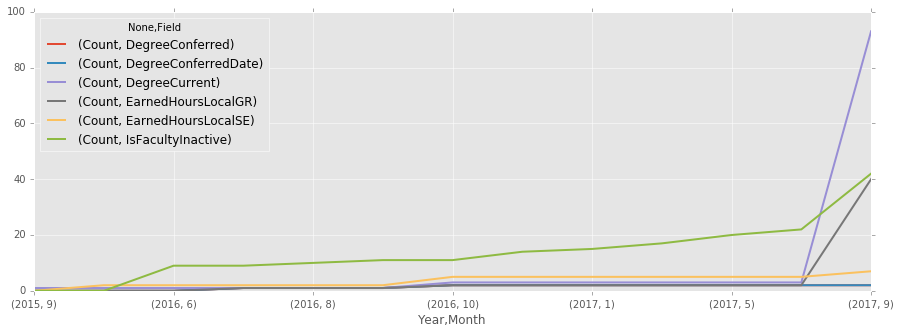

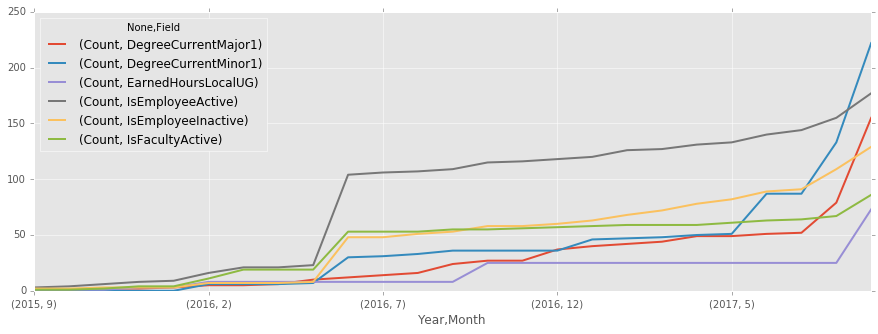

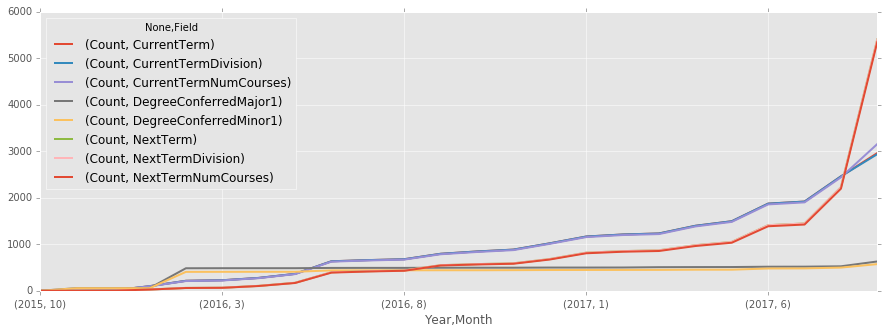

In [71]:
# Separate means into 3 buckets.
small = means.loc[means['Count'] < 15]['Field'].tolist()
medium = means.loc[(means['Count'] > 15) & (means['Count'] < 100)]['Field'].tolist()
large = means.loc[means['Count'] > 100]['Field'].tolist()

# PLot the buckets.
plt.rcParams['figure.figsize'] = (15, 5)
bymonth.loc[bymonth['Field'].isin(small)].pivot_table(index=['Year', 'Month'], columns='Field').fillna(0).cumsum().plot(linewidth=2)
bymonth.loc[bymonth['Field'].isin(medium)].pivot_table(index=['Year', 'Month'], columns='Field').fillna(0).cumsum().plot(linewidth=2)
bymonth.loc[bymonth['Field'].isin(large)].pivot_table(index=['Year', 'Month'], columns='Field').fillna(0).cumsum().plot(linewidth=2)

In [74]:
# Get the cumulative by month.
x = bymonth.pivot_table(index=['Year', 'Month'], columns='Field').fillna(0).cumsum()

# Sort by max value.
d = x.describe()
d = d.stack().reset_index()
maxs = d.loc[d['level_0'] == 'max']
maxs.sort_values('Count', ascending=False)

,level_0,Field,Count
157,max,NextTerm,5408
158,max,NextTermDivision,5408
159,max,NextTermNumCourses,5356
142,max,CurrentTermNumCourses,3157
140,max,CurrentTerm,2963
141,max,CurrentTermDivision,2939
145,max,DegreeConferredMajor1,631
146,max,DegreeConferredMinor1,574
149,max,DegreeCurrentMinor1,222
153,max,IsEmployeeActive,177


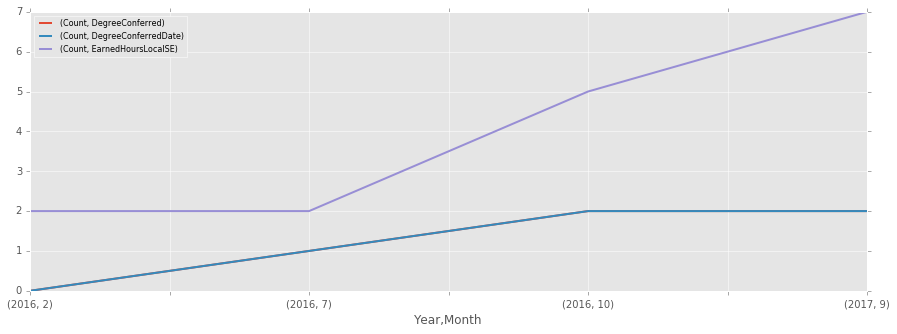

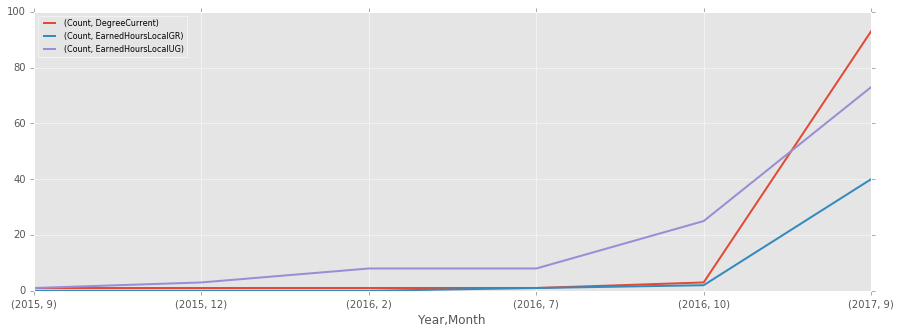

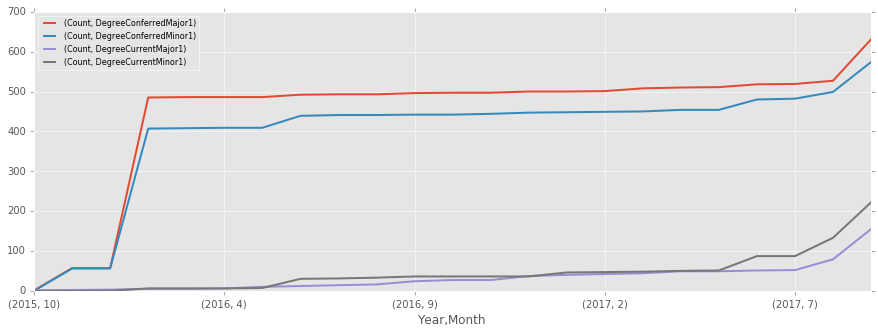

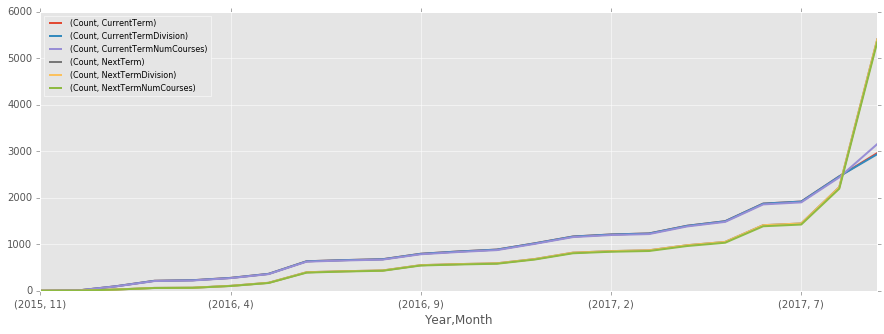

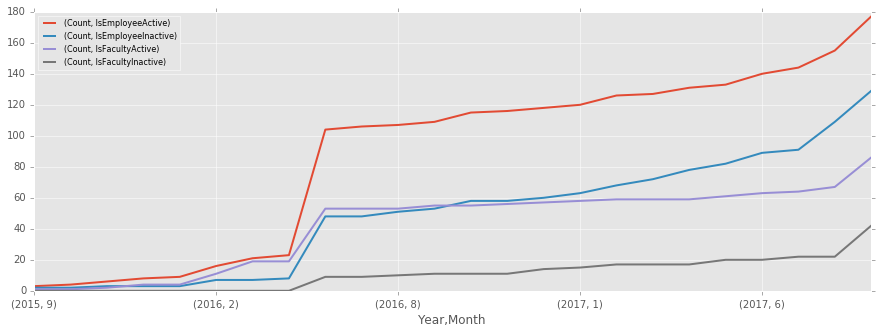

In [87]:
# Separate maxs into 3 buckets.
small = maxs.loc[maxs['Count'] < 10]['Field'].tolist()
medium = maxs.loc[(maxs['Count'] > 10) & (maxs['Count'] < 100)]['Field'].tolist()
large = maxs.loc[(maxs['Count'] > 100) & (maxs['Count'] < 1000)]['Field'].tolist()
xlarge = maxs.loc[maxs['Count'] > 1000]['Field'].tolist()

activeinactive = ['IsFacultyActive', 'IsFacultyInactive', 'IsEmployeeActive', 'IsEmployeeInactive']

# PLot the buckets.
plt.rcParams['figure.figsize'] = (15, 5)
for bucket in [small, medium, large, xlarge]:
    bymonth.loc[(bymonth['Field'].isin(bucket)) & (~bymonth['Field'].isin(activeinactive))].pivot_table(index=['Year', 'Month'], columns='Field').fillna(0).cumsum().plot(linewidth=2).legend(loc='best', prop={'size': 8})

bymonth.loc[bymonth['Field'].isin(activeinactive)].pivot_table(index=['Year', 'Month'], columns='Field').fillna(0).cumsum().plot(linewidth=2).legend(loc='best', prop={'size': 8})

## Plot each field

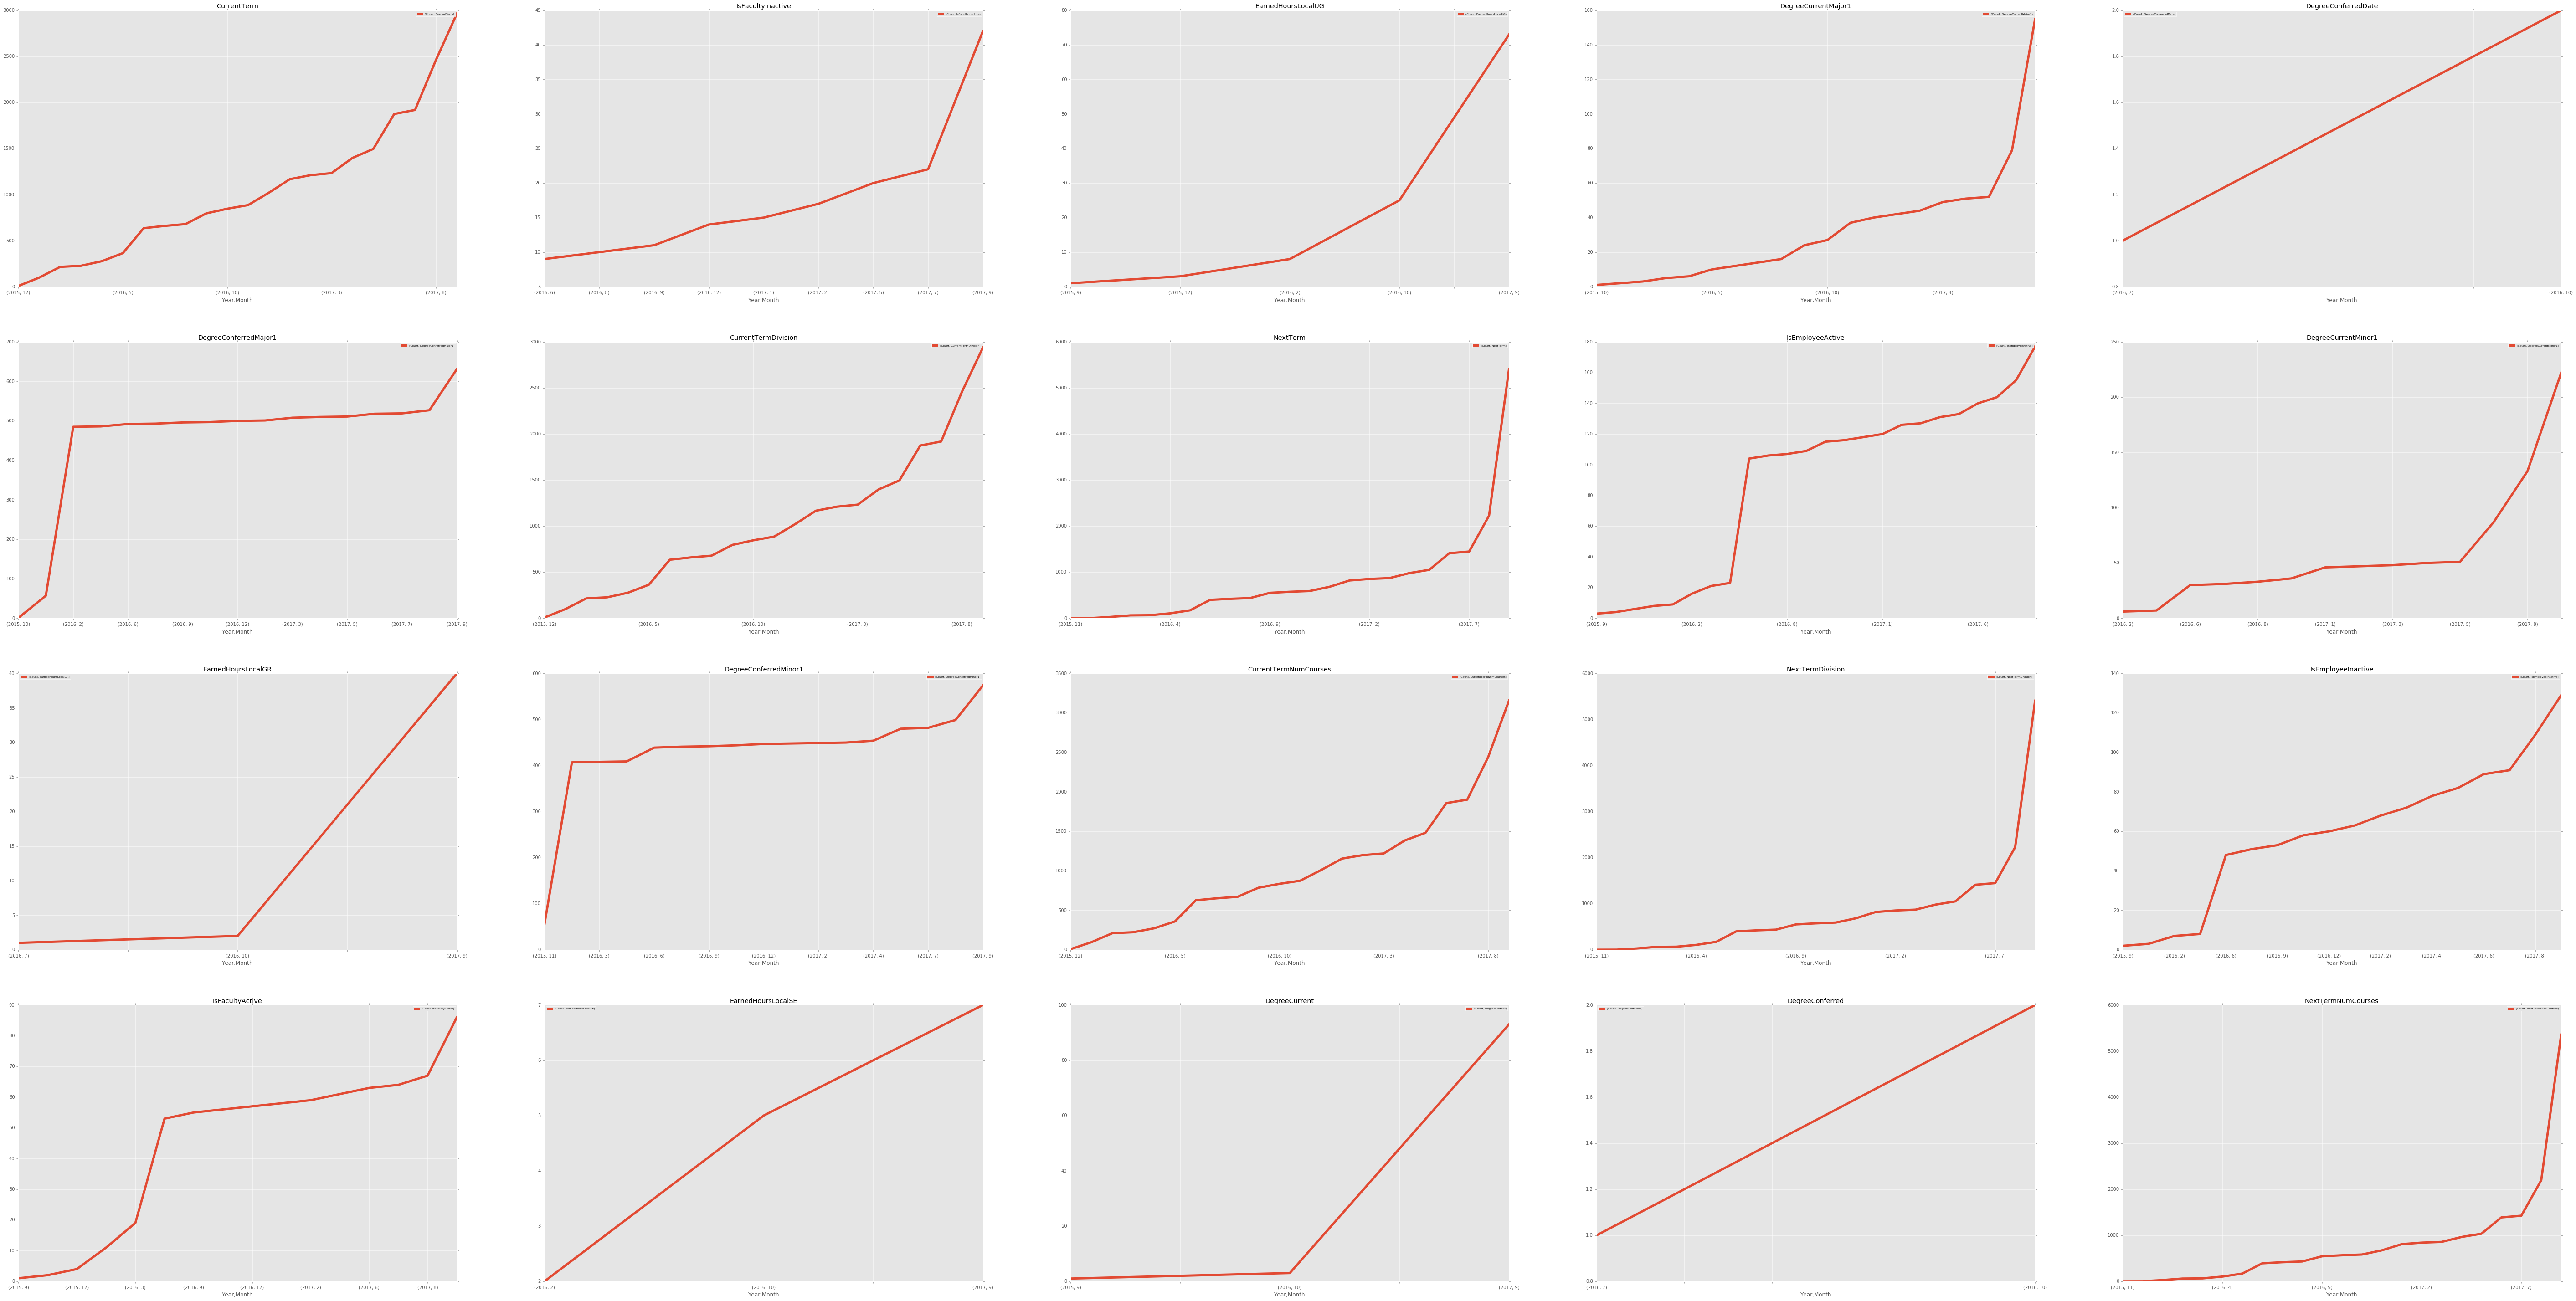

In [106]:
plt.rcParams['figure.figsize'] = (100, 50)

fig, axes = plt.subplots(nrows=4, ncols=5)
i = j = 0

for field in fail.reset_index()['Field'].tolist():
    x = bymonth.loc[bymonth['Field'] == field].pivot_table(index=['Year', 'Month'], columns='Field').fillna(0).cumsum()
    x.plot(title=field, ax=axes[i, j], linewidth=5).legend(loc='best', prop={'size': 6})
    i = i+1 if i < 3 else 0
    j = j+1 if j < 4 else 0